<a href="https://colab.research.google.com/github/sreeramulu/Data-Mining-for-CRM/blob/main/Rescue_Standby_Drivers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

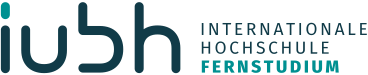

PPAOC Pipeline | Topics:
--- | ---
| <center> features, label, rescue,standby drivers,Regression, <br> Tuning,Polinomial Regression, XGBoost </center>

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).




# Intro
we are collaborating with Berlin's Red Cross rescue service to tackle a critical challenge in their daily operations – the efficient planning of standby duty for rescue drivers. As data science consultants, our mission is to leverage predictive modeling techniques to enhance the current standby duty planning process.

Currently, the rescue service faces a recurring issue where the number of rescue drivers required for duty often exceeds the initial estimates. This can be due to various factors, such as short-term sickness among rescue drivers or an unexpected surge in emergency calls. To address this, a contingent of standby drivers is always at the ready, poised to be activated when additional support is needed. Presently, this standby pool consists of 90 rescue drivers.

Our task is to refine this standby duty planning by incorporating more advanced forecasting models. The existing planning approach lacks the ability to adapt to seasonal patterns, such as increased sickness rates during winter months, which our predictive models can capture effectively. Furthermore, there are instances where even with the activation of all 90 standby drivers, there remains a shortage of rescue drivers available for duty, requiring drivers to be called in on their days off.

It's crucial to emphasize that the duty plan must be finalized by the 15th of the preceding month for the upcoming month. For instance, the November duty plan must be completed by October 15th. Our goal is to develop predictive models that not only account for seasonal variations but also optimize the allocation of standby drivers, reducing the need to call in drivers on their off-days. This approach aims to streamline the planning process, ensuring a robust and efficient response to emergencies while enhancing the well-being of rescue drivers..
<br>

# The Data and Structure

Before we even think about what algorithm works well for this task, we have to make sense of the data and ultimately convert it to an input matrix $X$ and the vector of labels $y$, **all numbers**.

# Loading of the Data

It always helps to start looking at the first few lines:

In [4]:
SDPRD_FILE = '/content/gdrive/My Drive/Colab Notebooks/AIAcademy/Data/sickness_table.csv'

# print the first few lines in this file
with open(SDPRD_FILE) as f:
  for i in range(5):
    print(f.readline())


,date,n_sick,calls,n_duty,n_sby,sby_need,dafted

0,2016-04-01,73,8154.0,1700,90,4.0,0.0

1,2016-04-02,64,8526.0,1700,90,70.0,0.0

2,2016-04-03,68,8088.0,1700,90,0.0,0.0

3,2016-04-04,71,7044.0,1700,90,0.0,0.0



(Reminder: Our task is to convert the above to a matrix of numbers $X$ and a vector of numbers $y$ so that we can apply some machine algorithm to the problem).

* the file format is CSV.
* The size of the file is 18MB so it should fit in memory without problem.

Let's use Pandas to read the whole csv file in memory.


In [5]:
# Use Pandas' read_csv method to read the whole file in memory
# Name the returned data frame "data"
import pandas as pd

data = pd.read_csv(SDPRD_FILE, index_col=0, encoding='latin')
data

,date,n_sick,calls,n_duty,n_sby,sby_need,dafted
0,2016-04-01,73,8154.0,1700,90,4.0,0.0
1,2016-04-02,64,8526.0,1700,90,70.0,0.0
2,2016-04-03,68,8088.0,1700,90,0.0,0.0
3,2016-04-04,71,7044.0,1700,90,0.0,0.0
4,2016-04-05,63,7236.0,1700,90,0.0,0.0
...,...,...,...,...,...,...,...
1147,2019-05-23,86,8544.0,1900,90,0.0,0.0
1148,2019-05-24,81,8814.0,1900,90,0.0,0.0
1149,2019-05-25,76,9846.0,1900,90,146.0,56.0
1150,2019-05-26,83,9882.0,1900,90,160.0,70.0


Column Description:

• **date:** entry date

• **n_sick:** number of drivers called sick on duty

• **calls:** number of emergency calls

• **n_duty:** number of drivers on duty available

• **n_sby:** number of standby resources available

• **sby_need:** number of standbys, which are activated on a given day

• **dafted:** number of additional drivers needed due to not enough standbys


# EDA Exporatory Data Analysis

Ok, we were able to load the csv in memory. <br>
Pandas provide the `describe()` method that gives a quick overview of the whole file:

In [6]:
data.describe()

,n_sick,calls,n_duty,n_sby,sby_need,dafted
count,1152.000000,1152.000000,1152.000000,1152.0,1152.000000,1152.000000
mean,68.808160,7919.531250,1820.572917,90.0,34.718750,16.335938
std,14.293942,1290.063571,80.086953,0.0,79.694251,53.394089
min,36.000000,4074.000000,1700.000000,90.0,0.000000,0.000000
25%,58.000000,6978.000000,1800.000000,90.0,0.000000,0.000000
50%,68.000000,7932.000000,1800.000000,90.0,0.000000,0.000000
75%,78.000000,8827.500000,1900.000000,90.0,12.250000,0.000000
max,119.000000,11850.000000,1900.000000,90.0,555.000000,465.000000


In [7]:
data.columns

Index(['date', 'n_sick', 'calls', 'n_duty', 'n_sby', 'sby_need', 'dafted'], dtype='object')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1152 entries, 0 to 1151
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   date      1152 non-null   object 
 1   n_sick    1152 non-null   int64  
 2   calls     1152 non-null   float64
 3   n_duty    1152 non-null   int64  
 4   n_sby     1152 non-null   int64  
 5   sby_need  1152 non-null   float64
 6   dafted    1152 non-null   float64
dtypes: float64(3), int64(3), object(1)
memory usage: 72.0+ KB


Key points:
* There are 1152 rows
* There are total of 7 columns: 6 numerical, 1 date object

1. Data Preparation:

In [9]:
# Handling Missing Values
# Check for missing values in the dataset
missing_values = data.isnull().sum()
missing_values

date        0
n_sick      0
calls       0
n_duty      0
n_sby       0
sby_need    0
dafted      0
dtype: int64

In [10]:
# Remove all columns with only one unique value.
unique = data.nunique()
unique = unique[unique.values == 1]
print(unique)
data.drop(labels = list(unique.index), axis =1, inplace=True)

n_sby    1
dtype: int64


n_sby column has only one unique value 90, so it is removed.

In [11]:
data.columns

Index(['date', 'n_sick', 'calls', 'n_duty', 'sby_need', 'dafted'], dtype='object')

# Data Preprocessing for EDA

Add 'day_of_week', 'month', 'season'

In [12]:
import pandas as pd

# Convert it to datetime
data['date'] = pd.to_datetime(data['date'])

# Now we can use the .dt accessor to get the day of the week
data['day_of_week'] = data['date'].dt.strftime('%a')
# Convert the month to abbreviated month name
data['month'] = data['date'].dt.strftime('%b')

# Define a function to categorize months into seasons
def categorize_season(month):
    if month in [12, 1, 2]:  # December, January, and February are winter months
        return 'Winter'
    elif month in [3, 4, 5]:  # March, April, and May are spring months
        return 'Spring'
    elif month in [6, 7, 8]:  # June, July, and August are summer months
        return 'Summer'
    else:
        return 'Fall'  # September, October, and November are fall months

# Apply the categorize_season function to create a new 'season' column
data['season'] = data['date'].dt.month.map(categorize_season)

# Print the DataFrame with the 'season' column
print(data)

# This code will categorize the dates into seasons based on the month and create a new 'season' column in your DataFrame. You can modify the categorize_season function to define your own season categorization rules if needed.

           date  n_sick   calls  n_duty  sby_need  dafted day_of_week month  \
0    2016-04-01      73  8154.0    1700       4.0     0.0         Fri   Apr   
1    2016-04-02      64  8526.0    1700      70.0     0.0         Sat   Apr   
2    2016-04-03      68  8088.0    1700       0.0     0.0         Sun   Apr   
3    2016-04-04      71  7044.0    1700       0.0     0.0         Mon   Apr   
4    2016-04-05      63  7236.0    1700       0.0     0.0         Tue   Apr   
...         ...     ...     ...     ...       ...     ...         ...   ...   
1147 2019-05-23      86  8544.0    1900       0.0     0.0         Thu   May   
1148 2019-05-24      81  8814.0    1900       0.0     0.0         Fri   May   
1149 2019-05-25      76  9846.0    1900     146.0    56.0         Sat   May   
1150 2019-05-26      83  9882.0    1900     160.0    70.0         Sun   May   
1151 2019-05-27      77  8790.0    1900       0.0     0.0         Mon   May   

      season  
0     Spring  
1     Spring  
2     

In [13]:
# removing date cloumn
data = data.drop('date', axis=1)
data.columns

Index(['n_sick', 'calls', 'n_duty', 'sby_need', 'dafted', 'day_of_week',
       'month', 'season'],
      dtype='object')

Create visualizations to provide insights into the data. Matplotlib, Seaborn, and Plotly are popular Python libraries for data visualization.

Box Plot:
To understand the distribution of data in a feature after handling outliers

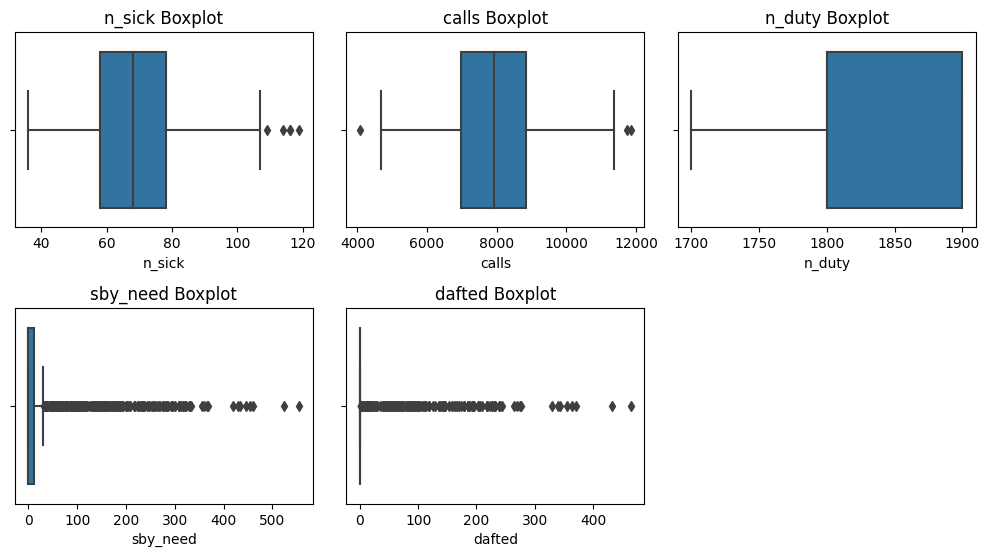

In [14]:
# Visualize the boxplot of each variable.
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
for i, j in enumerate(data.describe().columns):
    plt.subplot(3,3, i+1)
    sns.boxplot(x=data[j])
    plt.title('{} Boxplot'.format(j))
    plt.tight_layout()

plt.show()

The above box plots show the distribution of the continuous features present over the full dataset.

Feature calls seems normal without skew and has few outliers at both tails.

Feature n_duty negatively skewed (left skew) and no outliers.

Features sby_need and dafted are right skewed and has a lot of outliers at the right tail.

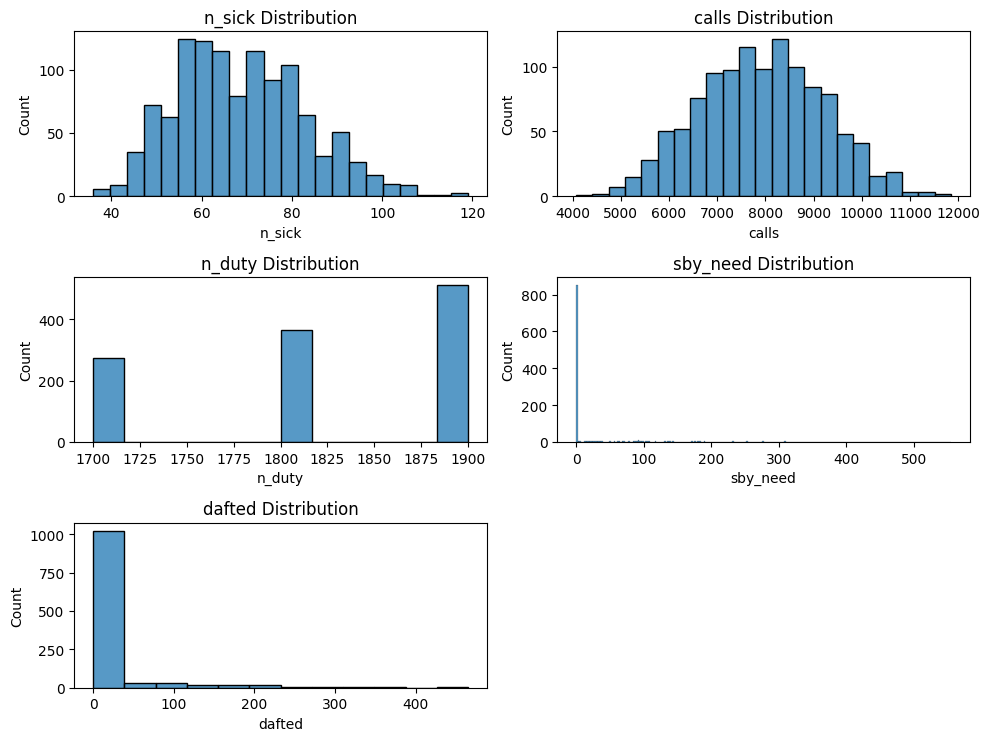

In [15]:
# Visualize the distribution of each variable.
plt.figure(figsize=(10,12))
for i, j in enumerate(data.describe().columns):
    plt.subplot(5,2, i+1)
    sns.histplot(x=data[j])
    plt.xlabel(j)
    plt.title('{} Distribution'.format(j))
    plt.tight_layout()
plt.show()

In [16]:
cat_cols=data.select_dtypes(include='object').columns.to_list()
cat_cols

['day_of_week', 'month', 'season']

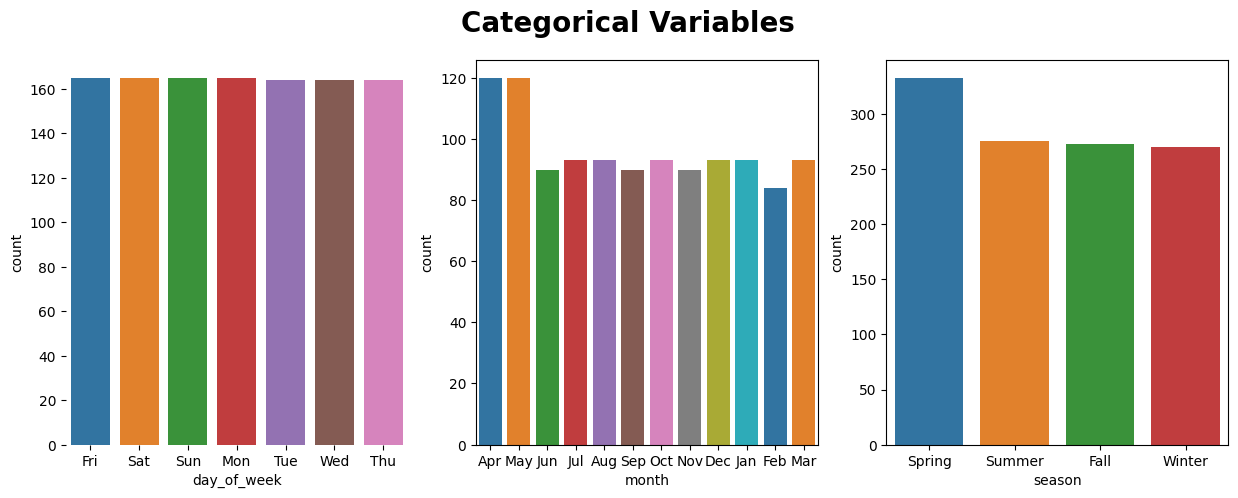

In [17]:
cat_cols=data.select_dtypes(include='object').columns.to_list()
fig=plt.figure(figsize=(15,5))
plt.suptitle("Categorical Variables", size=20, weight='bold')
ax1=plt.subplot(131)
sns.countplot(data=data, x=cat_cols[0], ax=ax1, linewidth=2, palette='tab10')
for s in ['left','right','top','bottom']:
        ax1.spines[s].set_visible(False)

ax2=plt.subplot(132)
sns.countplot(data=data, x=cat_cols[1], ax=ax2, linewidth=2, palette='tab10')
for s in ['left','right','top','bottom']:
        ax1.spines[s].set_visible(False)

ax3=plt.subplot(133)
sns.countplot(data=data, x=cat_cols[2], ax=ax3, linewidth=2, palette='tab10')
for s in ['left','right','top','bottom']:
        ax1.spines[s].set_visible(False)


filtering the categorical features and continuous features

In [18]:
target = "sby_need"
continous_col=data.select_dtypes(exclude='object').columns.to_list()
features = [col for col in data.columns if col != target]
cat_features= [col for col in features if col in cat_cols]
con_features= [col for col in features if col in continous_col]
print(cat_features)
print(con_features)

['day_of_week', 'month', 'season']
['n_sick', 'calls', 'n_duty', 'dafted']


In [19]:
# Outliers clipping

def get_outliers_clipped(dataframe, col_name):
    """
    Function to clip outliers and handle them for categorical features
    """
    dataframe = dataframe.copy()
    q25 = dataframe[col_name].quantile(0.25)
    q75 = dataframe[col_name].quantile(0.75)
    iqr = q75 - q25
    upper_limit = q75 + 1.5 * iqr
    lower_limit = q25 - 1.5 * iqr
    outlier_idx = (dataframe[col_name] > upper_limit) | (dataframe[col_name] < lower_limit)
    print(round(100 * outlier_idx.sum() / len(dataframe), 2), "% outliers clipped in feature ", col_name)
    dataframe.loc[dataframe.loc[:, col_name] > upper_limit, col_name] = upper_limit
    dataframe.loc[dataframe.loc[:, col_name] < lower_limit, col_name] = lower_limit
    return dataframe

# Checking Skew data
Checking kurtosis(amount of data in the tail)</br>
Clipping outliers for skewed features with low data in tail


In [20]:
from scipy.stats import skew
from scipy.stats import kurtosis

numeric_cols = data.select_dtypes(include=['float64', 'int64'])
skew_values = skew(numeric_cols)
kurtosis_values = kurtosis(numeric_cols)

df_clipped = data.copy()
for i, col in enumerate(con_features):
    print('Column: ', col, ' Skew: ', skew_values[i], ' Kurtosis: ', kurtosis_values[i])
    if skew_values[i] > 1.0:
        skewness = 'Positive'
    elif skew_values[i] < -1:
        skewness = 'Negative'
    else:
        skewness = 'No'
    if kurtosis_values[i] > 1.5:
        kurtic = 'Leptokurtic'
    elif kurtosis_values[i] < -1.5:
        kurtic = 'Platykurtic'
    else:
        kurtic = 'Mesokurtic'
    print('Skewness: ', skewness)
    print('Kurtosis: ', kurtic)

    if (skewness == 'Positive' or skewness == 'Negative') and (kurtic == 'Mesokurtic' or kurtic == 'Platykurtic'):
        df_clipped = get_outliers_clipped(df_clipped, col)
    print()

Column:  n_sick  Skew:  0.40120378637795573  Kurtosis:  -0.19944315979822846
Skewness:  No
Kurtosis:  Mesokurtic

Column:  calls  Skew:  0.024128785438697932  Kurtosis:  -0.3808562633457897
Skewness:  No
Kurtosis:  Mesokurtic

Column:  n_duty  Skew:  -0.38692534523470046  Kurtosis:  -1.3393616856536925
Skewness:  No
Kurtosis:  Mesokurtic

Column:  dafted  Skew:  2.8481454964483195  Kurtosis:  8.75476242131158
Skewness:  Positive
Kurtosis:  Leptokurtic



we have kept a threshold of ±1 to define skewness:

x > 1 - Positively Skewed (Right Skew)

x < -1 - Negatively Skewed (Left Skew)

-1 < x < 1 - No Skew

we have kept a threshold of ±1.5 to define kurtosis:

x > 1.5 - Leptokurtic (more information in tails) (heavy-tailed) (Fisher’s definition, high positive values)

x < -1.5 - Platykurtic (less information in tails) (thin-tailed) (Fisher’s definition, negative values)

-1.5 < x < 1.5 - Mesokurtic (perfectly normal) (Fisher’s definition, the kurtosis of the normal distribution is zero or close to zero)

For handling of outliers, we are checking both skewness and kurtosis values for the numerical features.

If Skewness is high in either positive or negative directions, we check for kurtosis and if and only if the kurtosis is not heavy tailed (Leptokurtic), we are removing or clipping the outliers for that continuous feature. Otherwise, we are leaving the outliers as such as they have some significant information present in the tails.

#Redundant work, Can be deleted

Box Plot
To understand the distribution of data in a feature after handling outliers


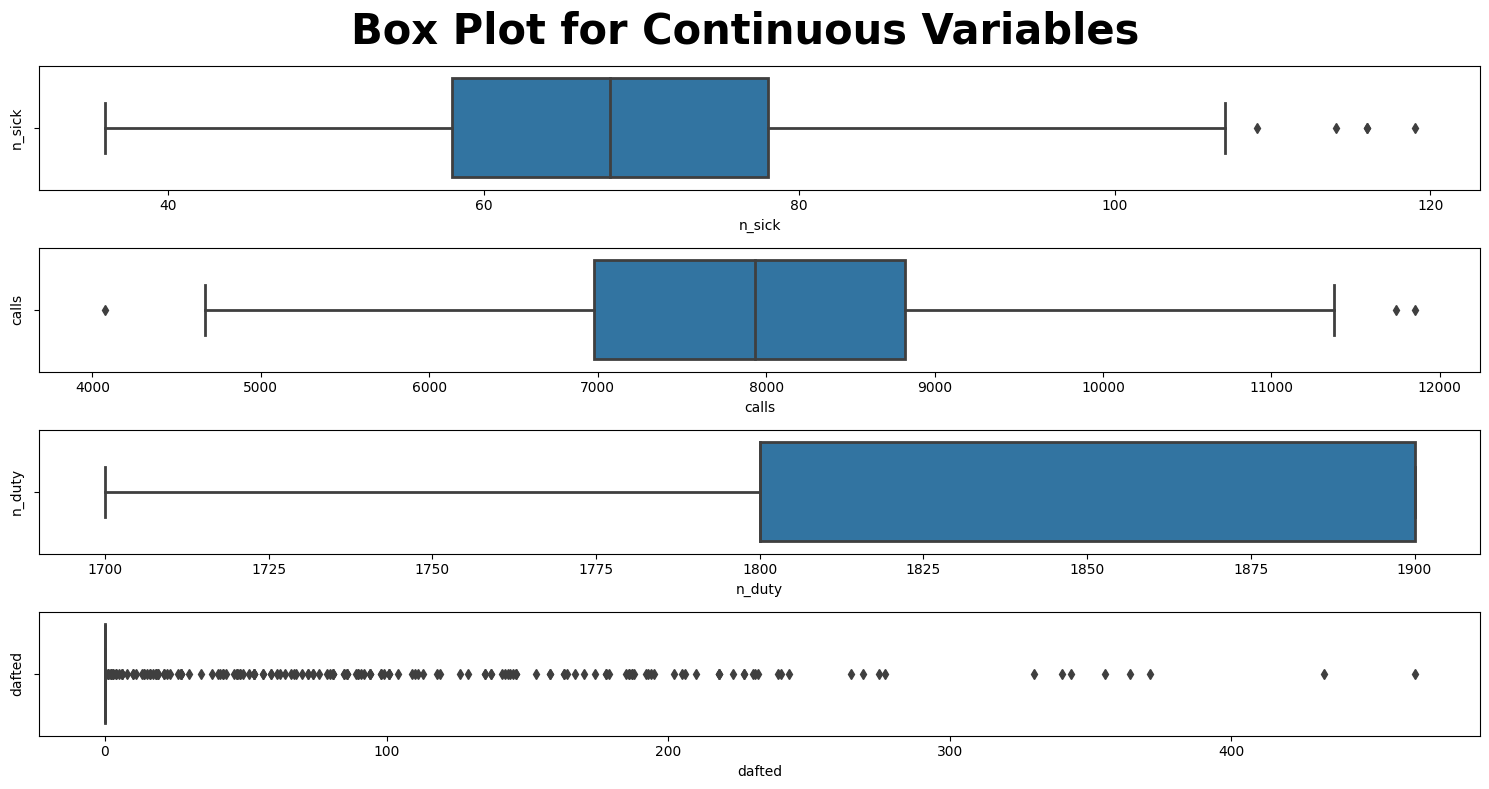

In [21]:
# Can be deleted
print("Box Plot")
print("To understand the distribution of data in a feature after handling outliers")
continuous_cols = df_clipped.select_dtypes(exclude='object').columns.to_list()

fig, axes = plt.subplots(len(con_features), 1, figsize=(15, 2 * (len(con_features))))
plt.suptitle("Box Plot for Continuous Variables", size=30, weight='bold')

j = 0
for col in con_features:
    ax = axes[j]
    sns.boxplot(data=df_clipped, x=col, ax=ax, linewidth=2, palette='tab10')
    ax.set_ylabel(col)
    j += 1

plt.tight_layout()
plt.show()

# Correlation matrix with continuous features - Computing Pearson Correlation Coefficient

In [22]:
# Correlation matrix with continuous features - Computing Pearson Correlation Coefficient
corr_dataframe = df_clipped[data.describe().columns].corr()
corr_dataframe

,n_sick,calls,n_duty,sby_need,dafted
n_sick,1.000000,0.155371,0.459501,0.022321,0.016800
calls,0.155371,1.000000,0.364135,0.677468,0.557340
n_duty,0.459501,0.364135,1.000000,0.090654,0.084955
sby_need,0.022321,0.677468,0.090654,1.000000,0.945168
dafted,0.016800,0.557340,0.084955,0.945168,1.000000


#Correlation heatmap with continuous features

<ipython-input-23-91119346bd29>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_metrics=data.corr()


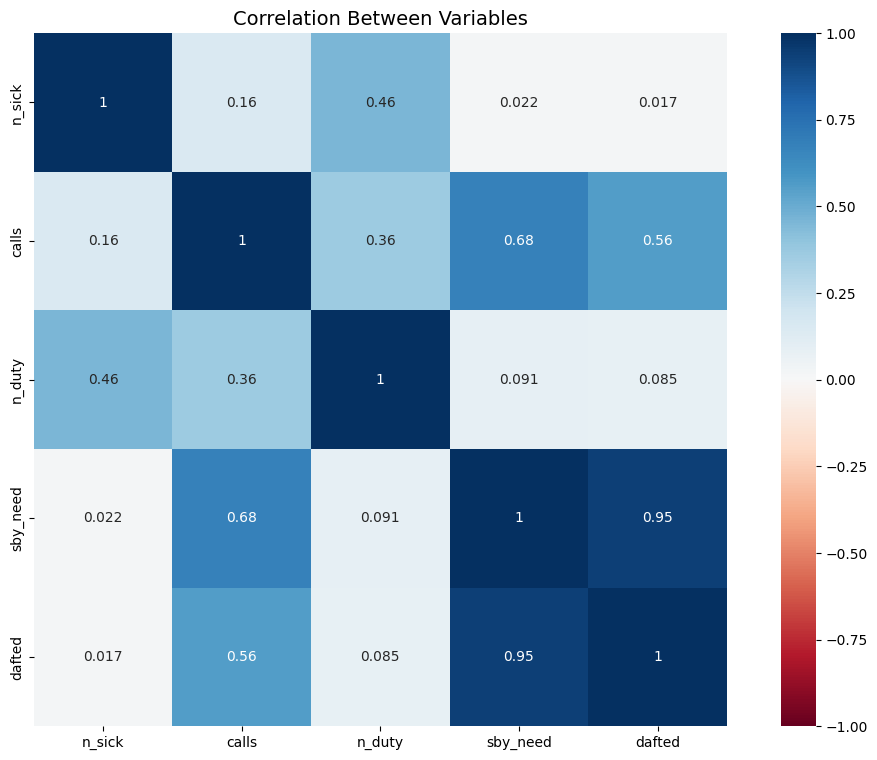

In [23]:
# Correlation heatmap with continuous features
correlation_metrics=data.corr()
fig = plt.figure(figsize=(14,9))
sns.heatmap(correlation_metrics,square=True, annot=True, vmax=1, vmin=-1, cmap='RdBu')
plt.title('Correlation Between Variables', size=14)
plt.show()

sby_need and dafted (very strong positive correlation)

sby_need and calls (moderate positive correlation)

dafted and calls (moderate positive correlation)

n_duty & n_sick (moderate positive correlation)

sby_need and dafted are the best features to estimate the amount of daily standby rescue drivers

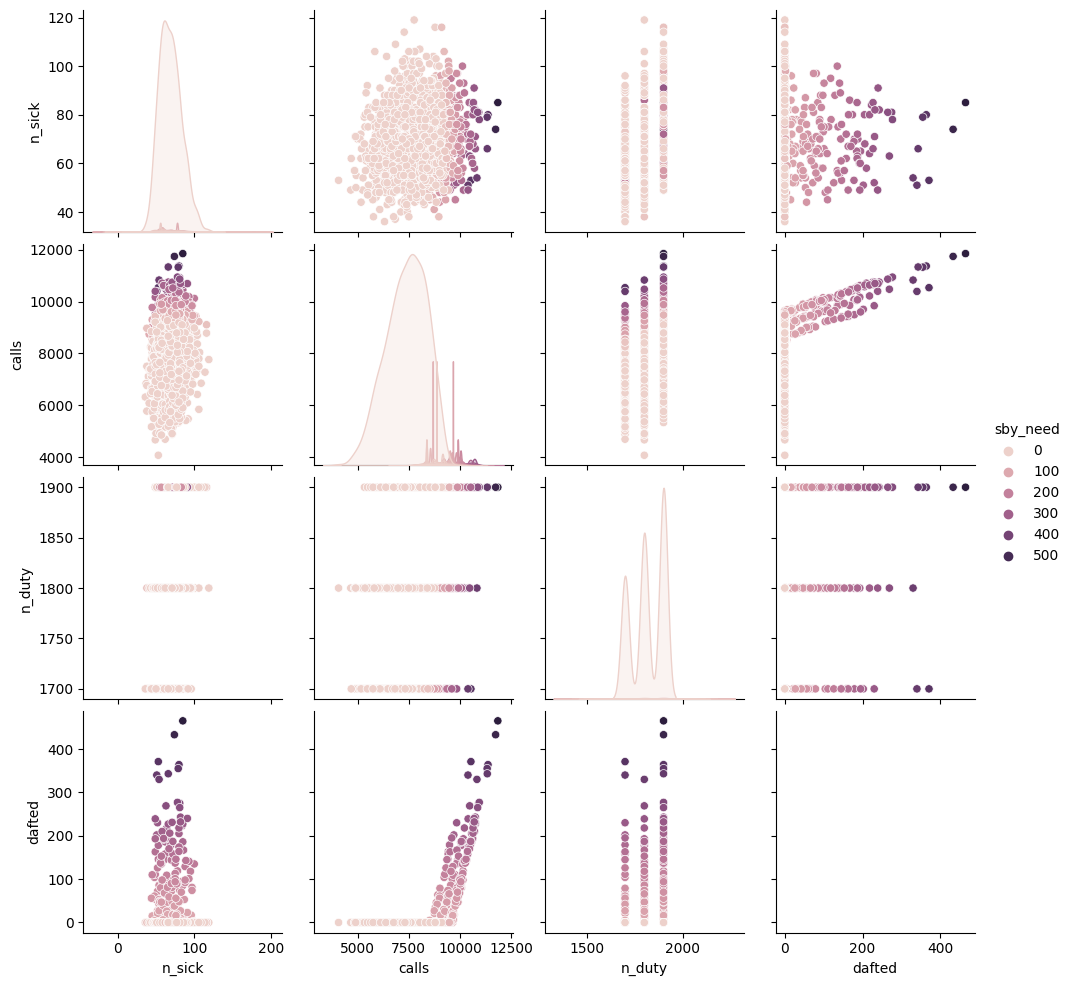

In [24]:
sns.pairplot(data=df_clipped, hue=target, vars=con_features)
plt.show()

# Visualization on group of attributes


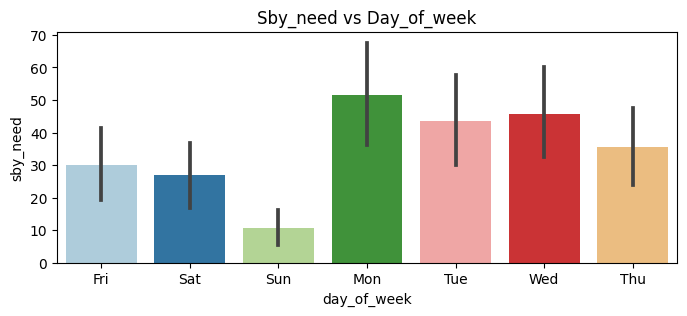

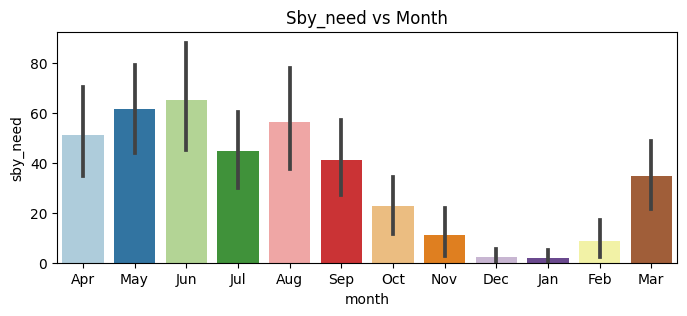

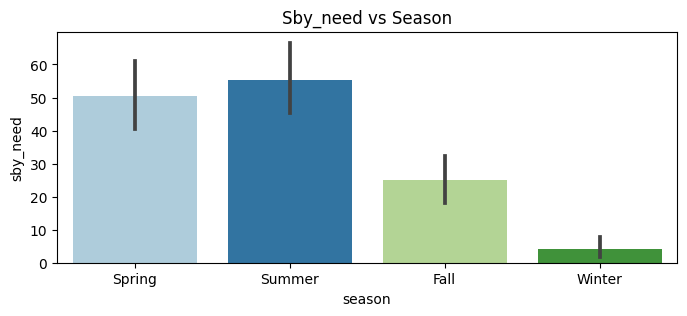

In [25]:
# Visualization on group of attributes
for col in cat_features:
    plt.figure(figsize = (8, 3))
    sns.barplot(x=col, y=target, data = data, palette='Paired')
    plt.title(target.capitalize() + ' vs ' + col.capitalize())
    plt.show()

Insights:
1. Standby drivers need is high in trend in Monday, Wednesday and Tuesday
2. More Standby drivers needed in June and May months
3. More Standby drivers are expected in Summer and Spring seasons

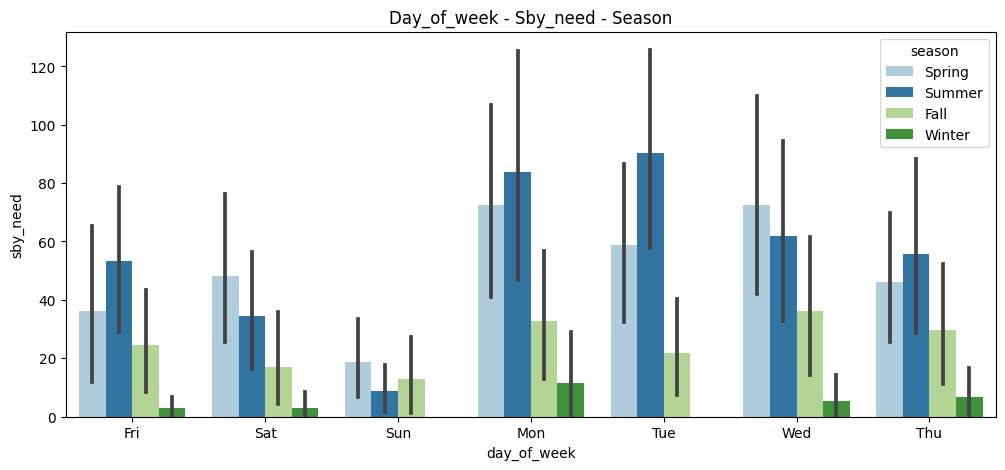

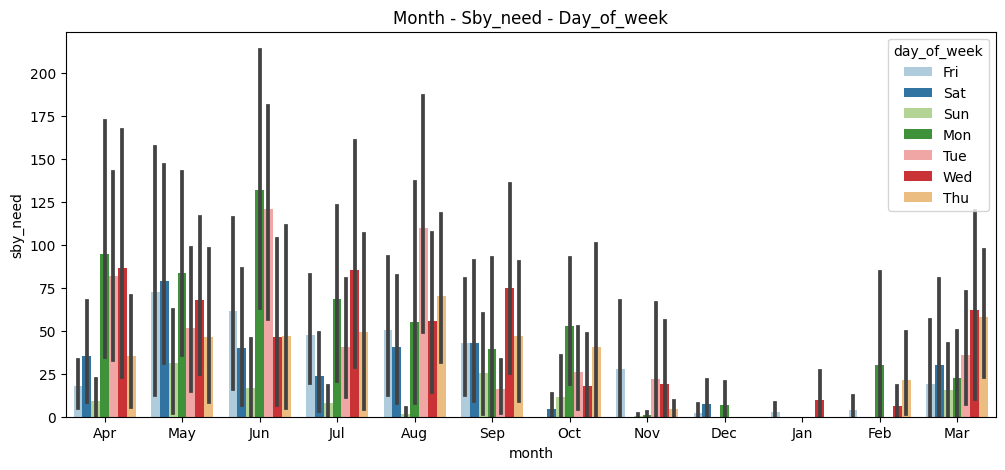

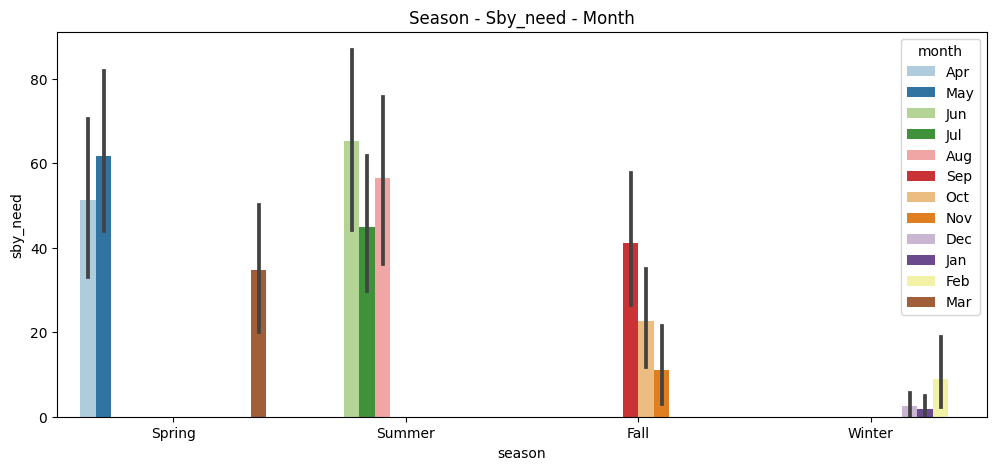

In [26]:
for col1, col2 in zip(cat_features, [cat_features[-1]] + cat_features[:-1]):
    plt.figure(figsize = (12, 5))
    sns.barplot(x=col1, y=target, hue=col2, data=data, palette='Paired')
    plt.title(col1.capitalize() + " - " + target.capitalize() + " - " + col2.capitalize())
    plt.show()

# Standardization using Standard scalar
# Standardization using MinMax Scaler

In [27]:
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

df_transformed = df_clipped.copy()

scaler = StandardScaler()
model = scaler.fit(df_transformed[con_features])
df_transformed[con_features] = model.transform(df_transformed[con_features])

# print scaled data
print(df_transformed[con_features])


scaler = MinMaxScaler()
model = scaler.fit(df_transformed[con_features])
df_transformed[con_features] = model.transform(df_transformed[con_features])


# print scaled features
print(df_transformed[con_features])

        n_sick     calls    n_duty    dafted
0     0.293387  0.181829 -1.506179 -0.306083
1    -0.336524  0.470312 -1.506179 -0.306083
2    -0.056563  0.130646 -1.506179 -0.306083
3     0.153407 -0.678968 -1.506179 -0.306083
4    -0.406514 -0.530073 -1.506179 -0.306083
...        ...       ...       ...       ...
1147  1.203258  0.484271  0.992191 -0.306083
1148  0.853308  0.693654  0.992191 -0.306083
1149  0.503358  1.493962  0.992191  0.743178
1150  0.993288  1.521879  0.992191  1.005493
1151  0.573348  0.675042  0.992191 -0.306083

[1152 rows x 4 columns]
        n_sick     calls  n_duty    dafted
0     0.445783  0.524691     0.0  0.000000
1     0.337349  0.572531     0.0  0.000000
2     0.385542  0.516204     0.0  0.000000
3     0.421687  0.381944     0.0  0.000000
4     0.325301  0.406636     0.0  0.000000
...        ...       ...     ...       ...
1147  0.602410  0.574846     1.0  0.000000
1148  0.542169  0.609568     1.0  0.000000
1149  0.481928  0.742284     1.0  0.120430
1150 

Applied 2 preprocessing data transformation operations:

1. Standardization - This is to normalize the data to standard normal form with mean = 0 and standard deviation = 1

2. Min Max Scaling - This is to normalize and re-scale the data to 0-1 range

# One-hot Encoding for Categorical data

In [28]:
# One-hot Encoding for Categorical data
df_transformed = pd.get_dummies(df_transformed, columns = cat_features)
df_transformed

,n_sick,calls,n_duty,sby_need,dafted,day_of_week_Fri,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,...,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,season_Fall,season_Spring,season_Summer,season_Winter
0,0.445783,0.524691,0.0,4.0,0.000000,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0.337349,0.572531,0.0,70.0,0.000000,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.385542,0.516204,0.0,0.0,0.000000,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,0.421687,0.381944,0.0,0.0,0.000000,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.325301,0.406636,0.0,0.0,0.000000,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.602410,0.574846,1.0,0.0,0.000000,0,0,0,0,1,...,0,0,1,0,0,0,0,1,0,0
1148,0.542169,0.609568,1.0,0.0,0.000000,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1149,0.481928,0.742284,1.0,146.0,0.120430,0,0,1,0,0,...,0,0,1,0,0,0,0,1,0,0
1150,0.566265,0.746914,1.0,160.0,0.150538,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0


For categorical features, performed One-Hot (Dummy) Encoding as pre-processing operation

In [29]:
ohe_cat_features = []
for col in cat_features:
    ohe_cols = [column for column in df_transformed.columns if column != col and column.startswith(col)]
    print(df_transformed[ohe_cols])
    ohe_cat_features += ohe_cols

      day_of_week_Fri  day_of_week_Mon  day_of_week_Sat  day_of_week_Sun  \
0                   1                0                0                0   
1                   0                0                1                0   
2                   0                0                0                1   
3                   0                1                0                0   
4                   0                0                0                0   
...               ...              ...              ...              ...   
1147                0                0                0                0   
1148                1                0                0                0   
1149                0                0                1                0   
1150                0                0                0                1   
1151                0                1                0                0   

      day_of_week_Thu  day_of_week_Tue  day_of_week_Wed  
0                   0        

# Correlation matrix with final dataframe

In [30]:
# Correlation matrix with final dataframe

corr_dataframe2 = df_transformed[con_features + ohe_cat_features].corr()
corr_dataframe2

,n_sick,calls,n_duty,dafted,day_of_week_Fri,day_of_week_Mon,day_of_week_Sat,day_of_week_Sun,day_of_week_Thu,day_of_week_Tue,...,month_Jun,month_Mar,month_May,month_Nov,month_Oct,month_Sep,season_Fall,season_Spring,season_Summer,season_Winter
n_sick,1.000000,0.155371,0.459501,0.016800,0.058734,0.067406,-0.120424,-0.005783,0.019728,-0.018524,...,-0.087099,-0.013640,-0.087307,-0.069215,0.340965,0.316098,0.374247,-0.149583,-0.236863,0.023062
calls,0.155371,1.000000,0.364135,0.557340,-0.011035,0.097992,-0.064304,-0.197429,0.020758,0.092587,...,0.113796,0.070578,0.159806,-0.127731,-0.037715,0.055521,-0.069735,0.211909,0.190237,-0.348459
n_duty,0.459501,0.364135,1.000000,0.084955,-0.002926,0.003265,-0.002926,0.000169,0.000808,0.000808,...,-0.074814,0.170633,0.008209,-0.074814,-0.076158,-0.074814,-0.143222,0.120778,-0.144253,0.159869
dafted,0.016800,0.557340,0.084955,1.000000,-0.023606,0.077564,-0.039532,-0.099704,-0.008988,0.036116,...,0.095136,-0.005328,0.101092,-0.057165,-0.042763,-0.005044,-0.066657,0.109362,0.106020,-0.156949
day_of_week_Fri,0.058734,-0.011035,-0.002926,-0.023606,1.000000,-0.167173,-0.167173,-0.167173,-0.166582,-0.166582,...,0.010243,0.015279,-0.009633,0.001010,-0.012010,0.010243,-0.000592,0.001665,0.002721,-0.003930
day_of_week_Mon,0.067406,0.097992,0.003265,0.077564,-0.167173,1.000000,-0.167173,-0.167173,-0.166582,-0.166582,...,-0.008224,-0.012010,0.006591,-0.008224,0.015279,-0.008224,-0.000592,0.001665,-0.003084,0.001919
day_of_week_Sat,-0.120424,-0.064304,-0.002926,-0.039532,-0.167173,-0.167173,1.000000,-0.167173,-0.166582,-0.166582,...,0.001010,0.006183,-0.009633,-0.008224,-0.002914,0.010243,-0.000592,0.001665,-0.003084,0.001919
day_of_week_Sun,-0.005783,-0.197429,0.000169,-0.099704,-0.167173,-0.167173,-0.167173,1.000000,-0.166582,-0.166582,...,-0.008224,-0.002914,-0.001521,-0.008224,0.006183,0.001010,-0.000592,0.001665,-0.003084,0.001919
day_of_week_Thu,0.019728,0.020758,0.000808,-0.008988,-0.166582,-0.166582,-0.166582,-0.166582,1.000000,-0.165992,...,0.010993,0.006934,-0.000678,0.010993,-0.011304,0.001736,0.000791,-0.002226,0.004123,-0.002566
day_of_week_Tue,-0.018524,0.092587,0.000808,0.036116,-0.166582,-0.166582,-0.166582,-0.166582,-0.165992,1.000000,...,-0.007521,-0.011304,0.007455,0.001736,0.006934,-0.007521,0.000791,-0.002226,-0.001698,0.003299


# Plotting the Pearson correlation coefficients of the features in final transformed
# feature dataframe vs target column


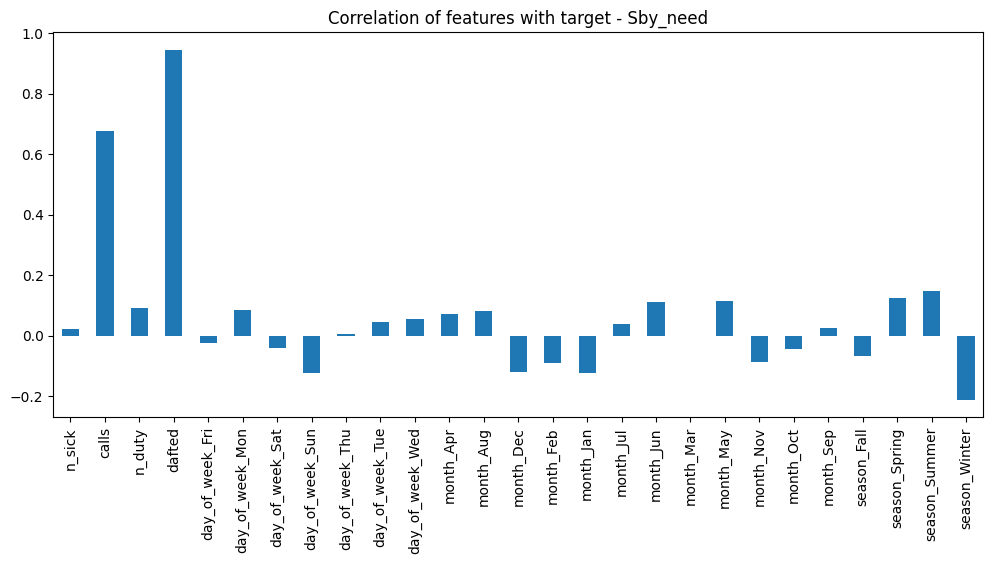

In [31]:
# Plotting the Pearson correlation coefficients of the features in final transformed
# feature dataframe vs target column

df_transformed[con_features + ohe_cat_features].corrwith(df_transformed[target]).plot.bar(
    figsize = (12, 5),
    title = 'Correlation of features with target - ' + target.capitalize()
)
plt.show()

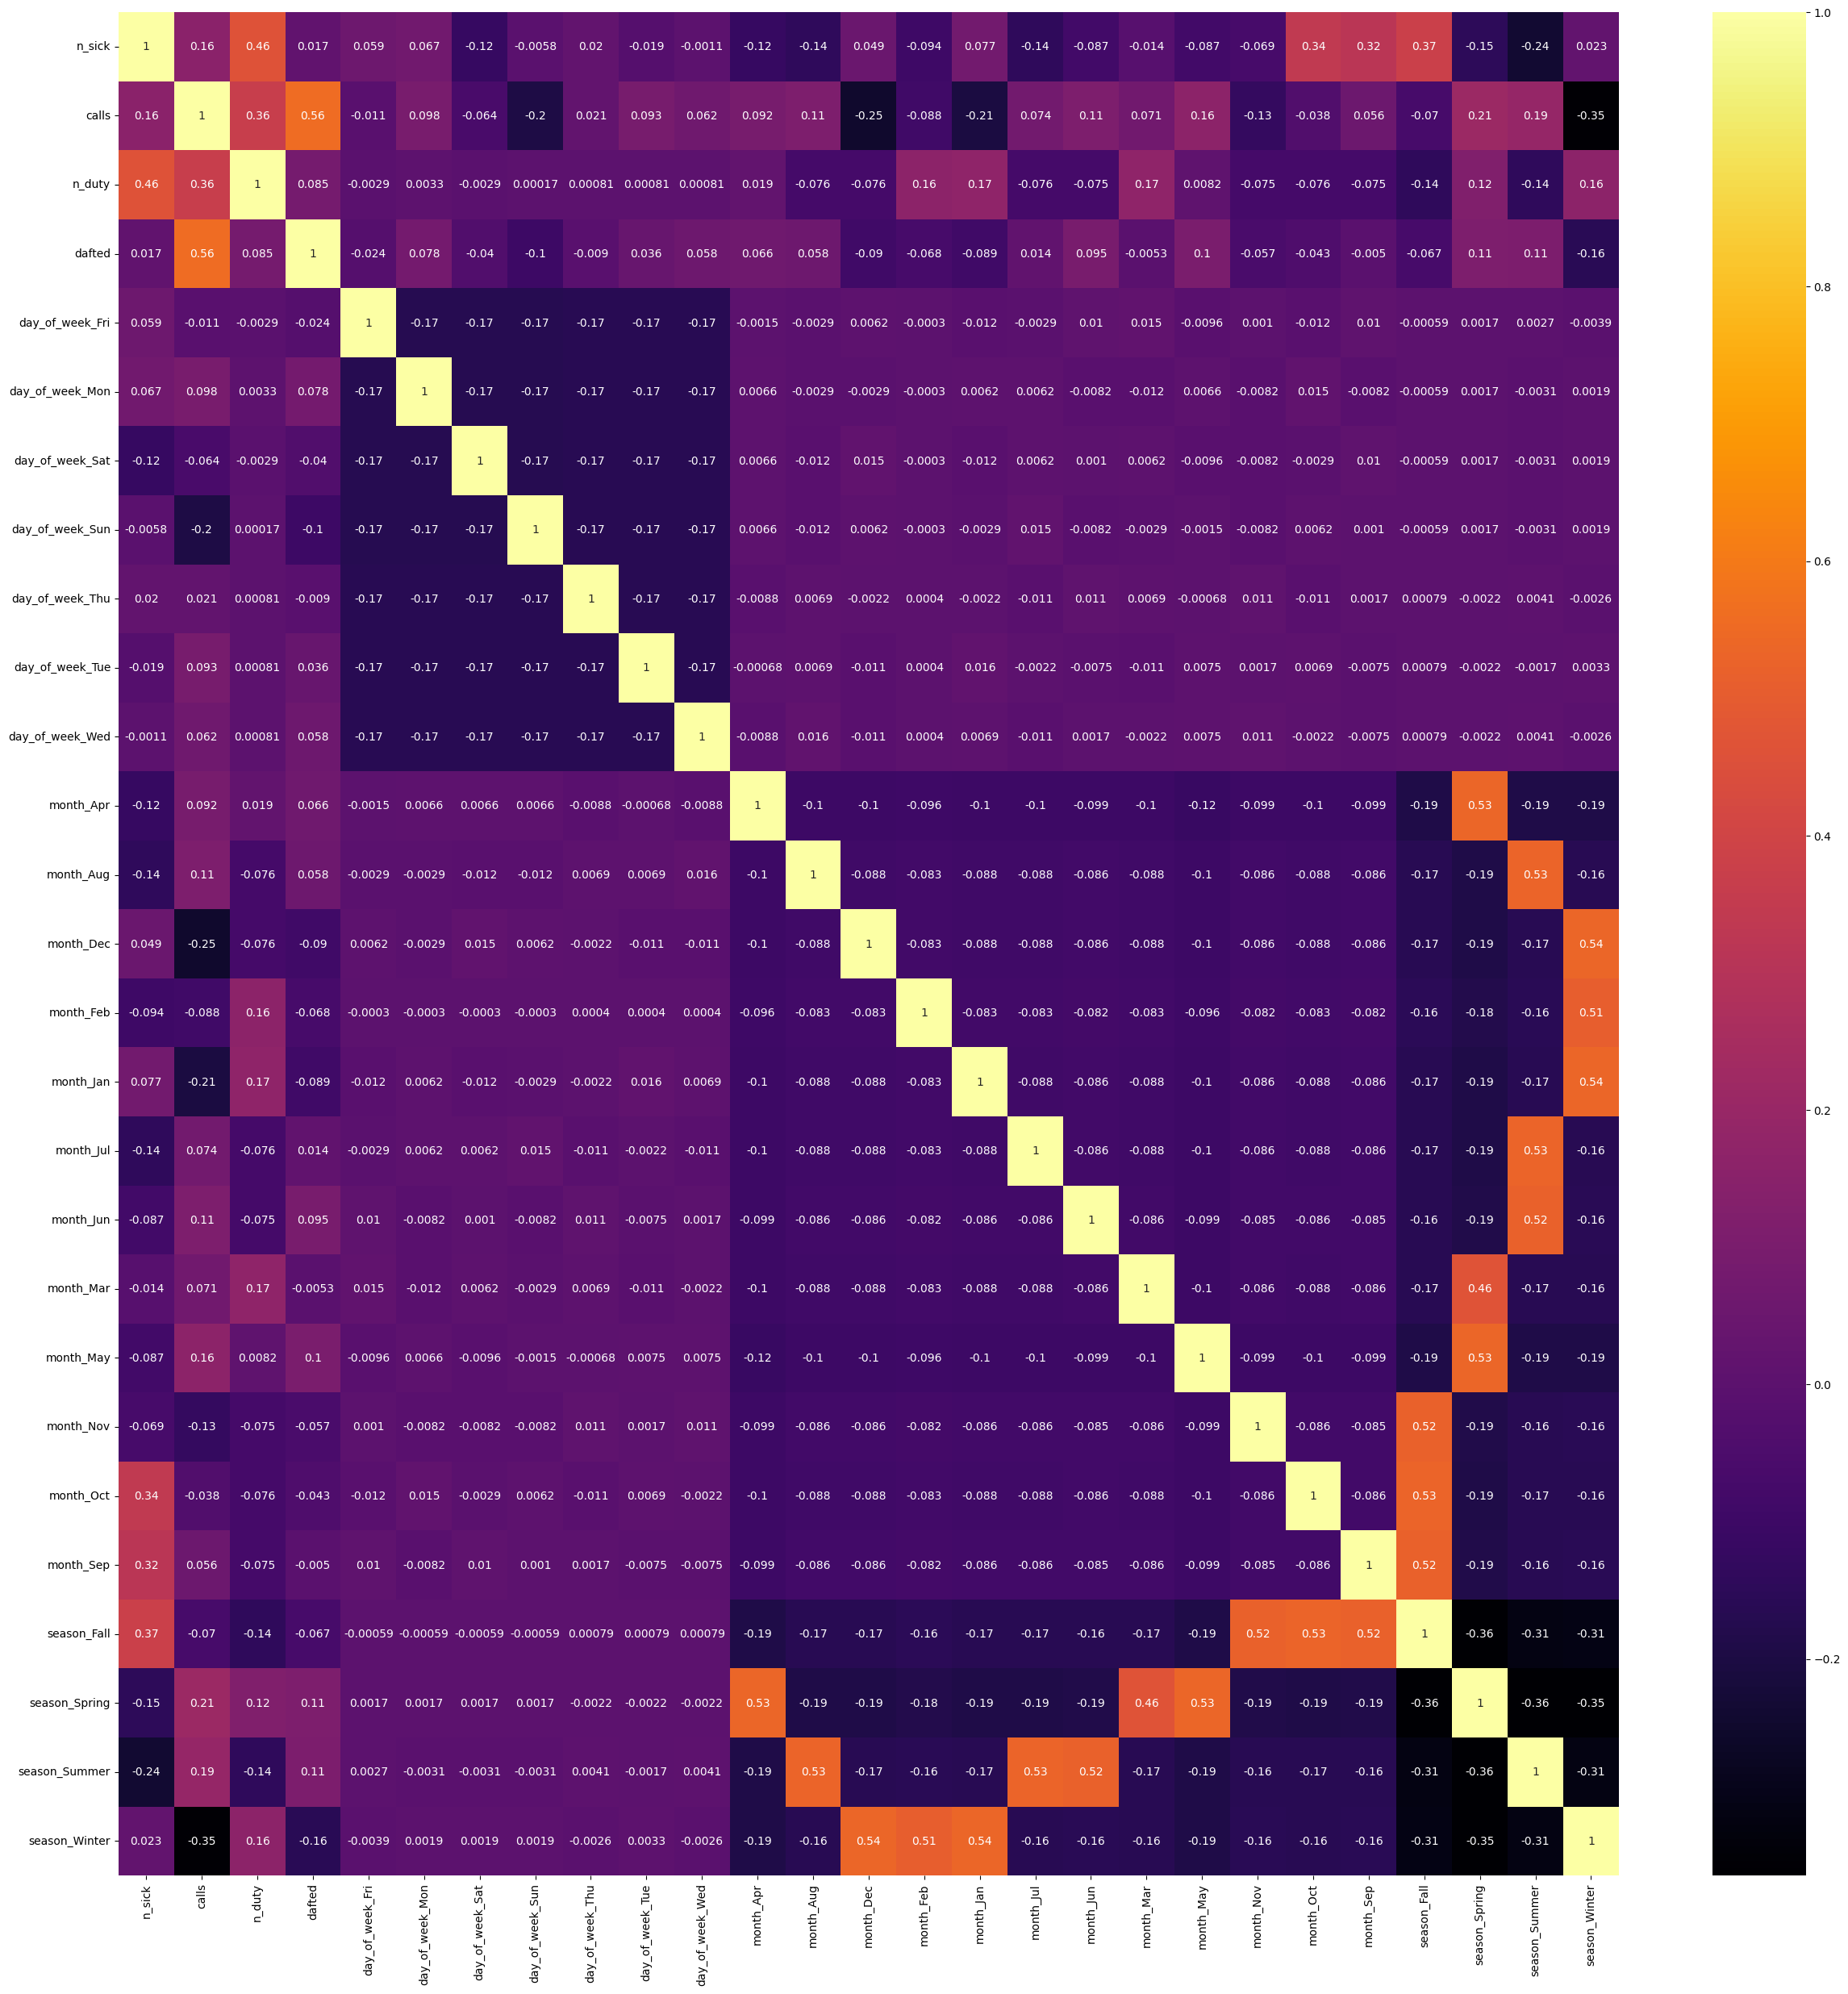

In [32]:
# Correlation matrix with final transformed dataframe

plt.figure(figsize = (30, 30))
sns.heatmap(corr_dataframe2,
            annot = True,
            cmap = 'inferno')
plt.show()

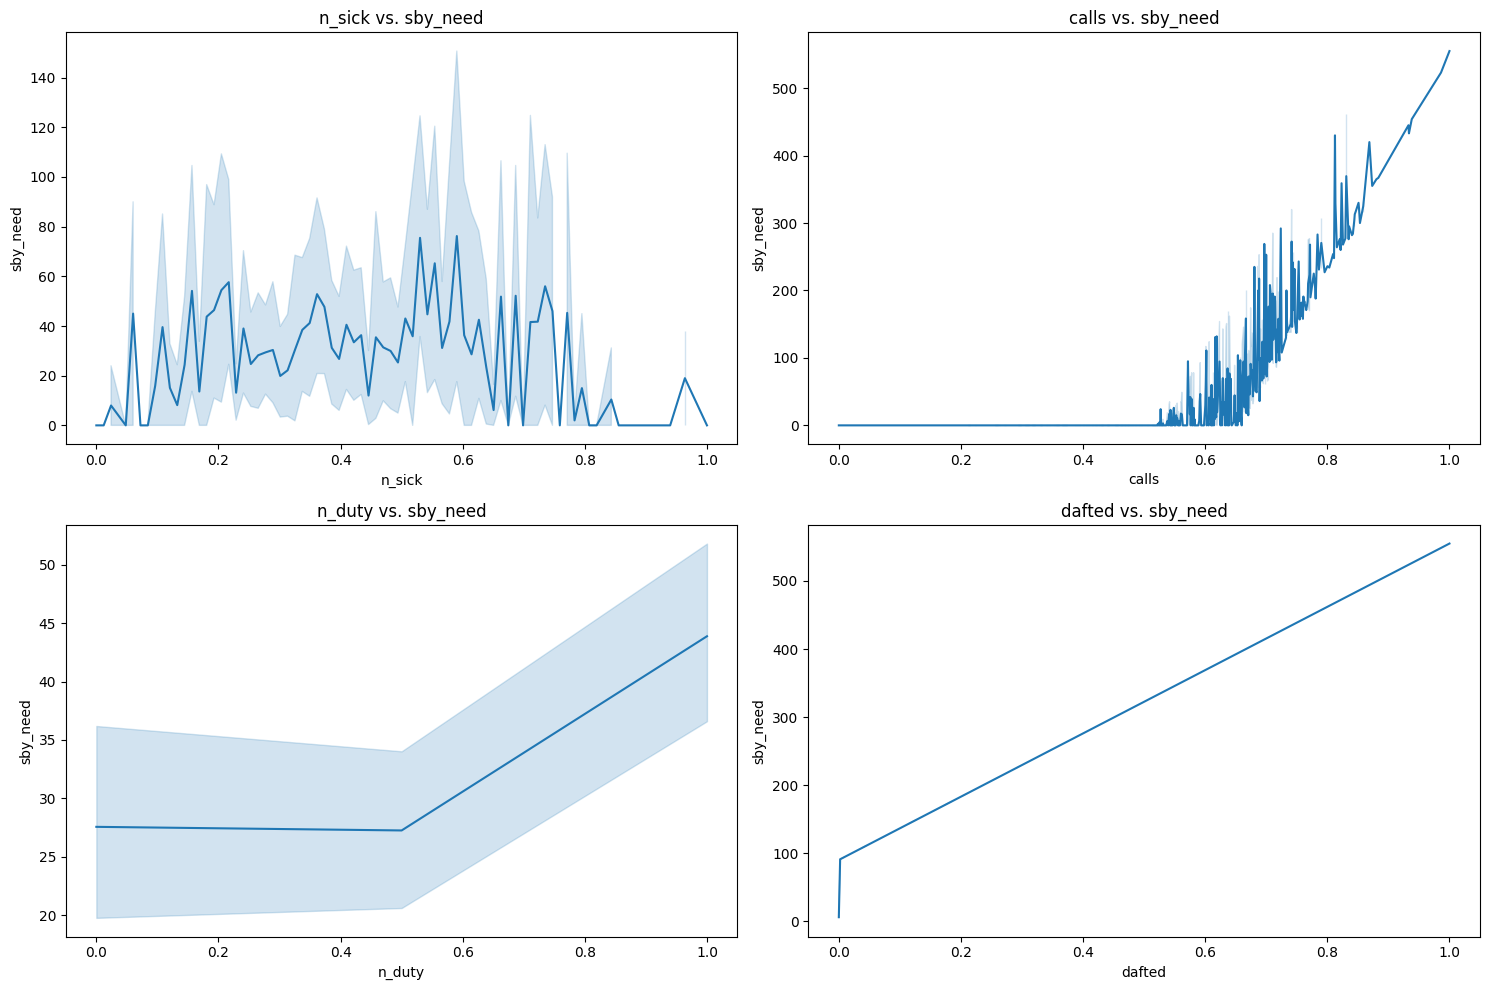

In [33]:
# Plotting each continuous feature vs target sby_need to see the trend
columns_to_plot = con_features
titles = [col + ' vs. ' + target for col in columns_to_plot]

rows = 2
columns = 2
fig, axes = plt.subplots(rows, columns, figsize = (15, 10))

for i, column in enumerate(columns_to_plot):
    sns.lineplot(x=column,
                 y=target,
                 data = df_transformed,
                 ax = axes[i//columns][i%columns])
    axes[i//columns][i%columns].set_title(titles[i])

plt.tight_layout()
plt.show()

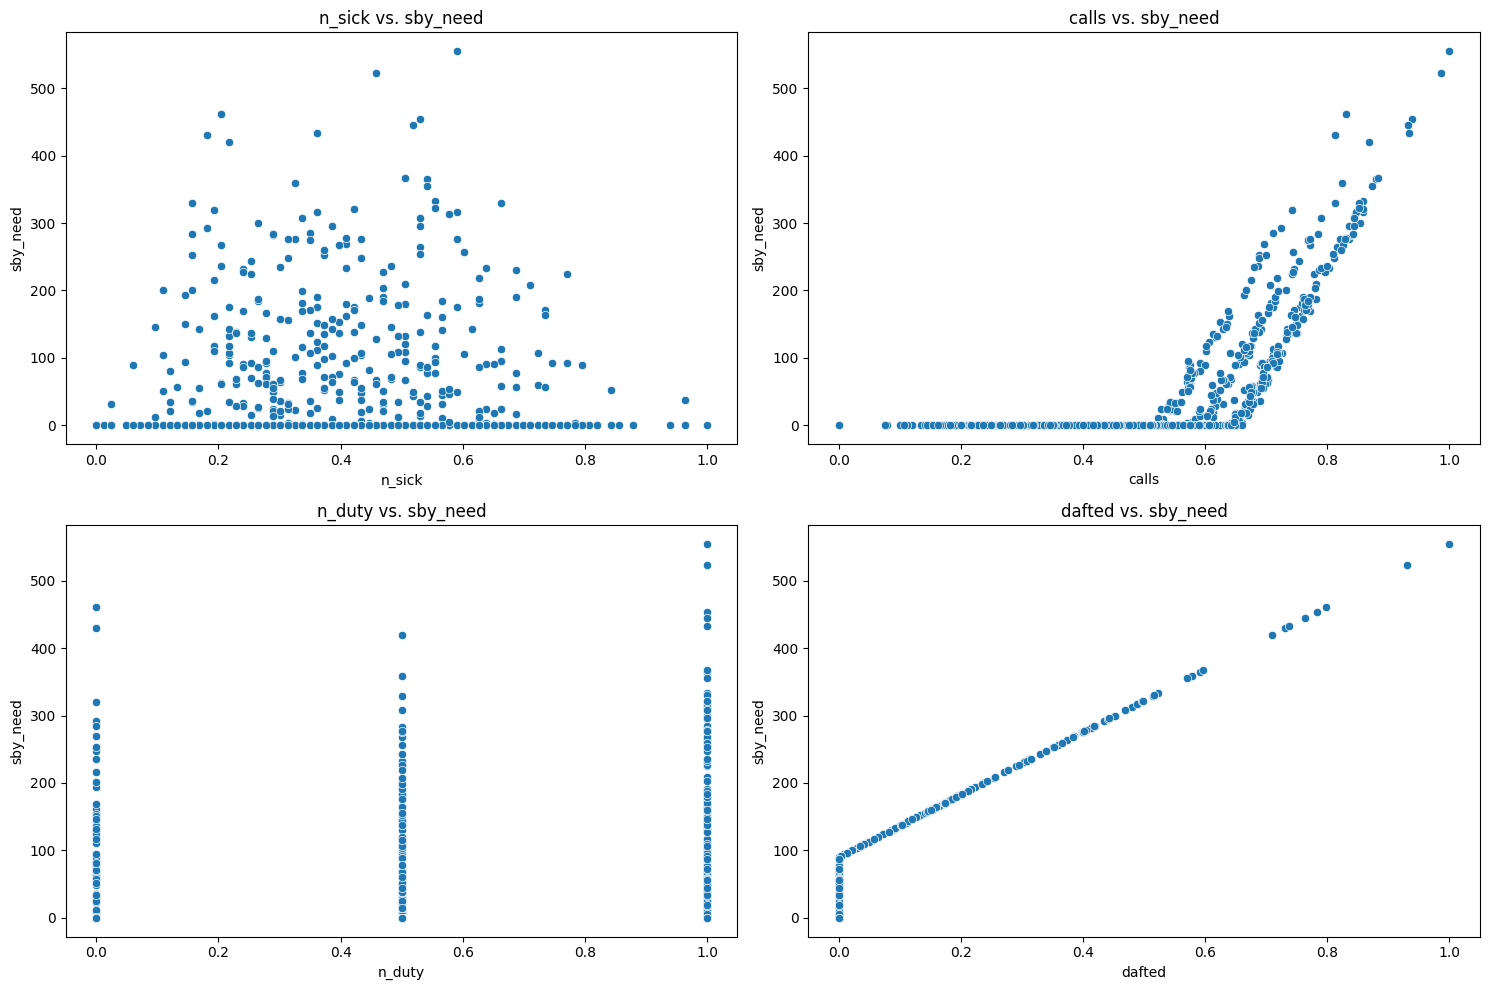

In [34]:
# Plotting each continuous feature's datapoints vs target price as scatter plot to observe the distribution

columns_to_plot = con_features
titles = [col + ' vs. ' + target for col in columns_to_plot]

rows = 2
columns = 2
fig, axes = plt.subplots(rows, columns, figsize = (15, 10))

for i, column in enumerate(columns_to_plot):
    sns.scatterplot(x = column, y=target, data = df_transformed, ax = axes[i//columns][i%columns])
    axes[i//columns][i%columns].set_title(titles[i])

plt.tight_layout()
plt.show()

In [35]:
 # final feature selection and extract them into Column X and the class label into Column into Y

X = df_transformed.drop(target, axis = 1)
y = df_transformed[target]


print('Features in X: ', ', '.join(con_features + ohe_cat_features))
print('Dimensions of X: ', X.shape)
print('X: ')
print(X)
print()
print('Target in y: ', target)
print('Dimensions of y: ', y.shape)
print('y: ')
print(y)

Features in X:  n_sick, calls, n_duty, dafted, day_of_week_Fri, day_of_week_Mon, day_of_week_Sat, day_of_week_Sun, day_of_week_Thu, day_of_week_Tue, day_of_week_Wed, month_Apr, month_Aug, month_Dec, month_Feb, month_Jan, month_Jul, month_Jun, month_Mar, month_May, month_Nov, month_Oct, month_Sep, season_Fall, season_Spring, season_Summer, season_Winter
Dimensions of X:  (1152, 27)
X: 
        n_sick     calls  n_duty    dafted  day_of_week_Fri  day_of_week_Mon  \
0     0.445783  0.524691     0.0  0.000000                1                0   
1     0.337349  0.572531     0.0  0.000000                0                0   
2     0.385542  0.516204     0.0  0.000000                0                0   
3     0.421687  0.381944     0.0  0.000000                0                1   
4     0.325301  0.406636     0.0  0.000000                0                0   
...        ...       ...     ...       ...              ...              ...   
1147  0.602410  0.574846     1.0  0.000000          

In [36]:
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

In [37]:
# Taken 20% data as unseen test data and the rest 80% for training and cross-validation

x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = RANDOM_SEED)

In [38]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((921, 27), (231, 27), (921,), (231,))

**1. Random Forest (Bagging Ensemble of Decision Trees)**
- Hyperparameters tuned via Randomized Search Cross-Validation with k = 7

In [39]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV

In [40]:
import numpy as np

# Hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [700]}

# Instantiate RandomizedSearchCV model
rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1, random_state=RANDOM_SEED),
                              param_distributions=rf_grid,
                              n_iter=2,
                              cv=7,
                              verbose=True)

In [41]:
# Fitting model - Performing CV
rs_model.fit(x_train, y_train)

Fitting 7 folds for each of 2 candidates, totalling 14 fits


RandomizedSearchCV(cv=7,
                   estimator=RandomForestRegressor(n_jobs=-1, random_state=42),
                   n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [700],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [42]:
# Best Model
model = rs_model.best_estimator_
print(model)

RandomForestRegressor(max_depth=5, max_features=0.5, max_samples=700,
                      min_samples_leaf=9, min_samples_split=4, n_estimators=80,
                      n_jobs=-1, random_state=42)


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def evaluate_model(model, x_data, y_data, data):
    """
    To evaluate the performance of the model on x_data using y_data
    """
    y_hat = model.predict(x_data)
    mse = mean_squared_error(y_data, y_hat, squared=False)
    mae = mean_absolute_error(y_data, y_hat)
    mape = mean_absolute_percentage_error(y_data, y_hat)
    print(data + ' Root Mean Squared Error: ', mse)
    print(data + ' Mean Absolute Error: ', mae)
    print(data + ' Mean Absolute Percentage Error: ', mape)

In [44]:
def plot_efficency(modelClass):
    """
    Function to plot the individual feature vs actual and predicted target values
    """
    y_predicted = modelClass.predict(X)
    columns_to_plot = con_features
    titles = [col + ' vs. ' + target for col in columns_to_plot]

    rows = 2
    columns = 2
    fig, axes = plt.subplots(rows, columns, figsize = (15, 10))

    for i, column in enumerate(columns_to_plot):
        sns.lineplot(x=column,
                  y=target,
                  data = df_transformed,
                  ax = axes[i//columns][i%columns],
                  legend='auto')
        sns.lineplot(x=df_transformed[column],
                  y=y_predicted,
                  ax = axes[i//columns][i%columns],
                  legend='auto')
        axes[i//columns][i%columns].set_title(titles[i])

    plt.tight_layout()
    plt.show()

    return y_predicted

In [45]:
# Evaluation on Train Data - Showing appropriate metrics for regression problems
evaluate_model(model, x_train, y_train, 'Train')

Train Root Mean Squared Error:  15.997140727879417
Train Mean Absolute Error:  7.400870521959911
Train Mean Absolute Percentage Error:  1.1214026282822448e+16


In [46]:
# Evaluation on Unseen Test Data - Showing appropriate metrics for regression problems
evaluate_model(model, x_test, y_test, 'Test')

Test Root Mean Squared Error:  10.532711628186554
Test Mean Absolute Error:  6.219981363675434
Test Mean Absolute Percentage Error:  1.1130167437359996e+16


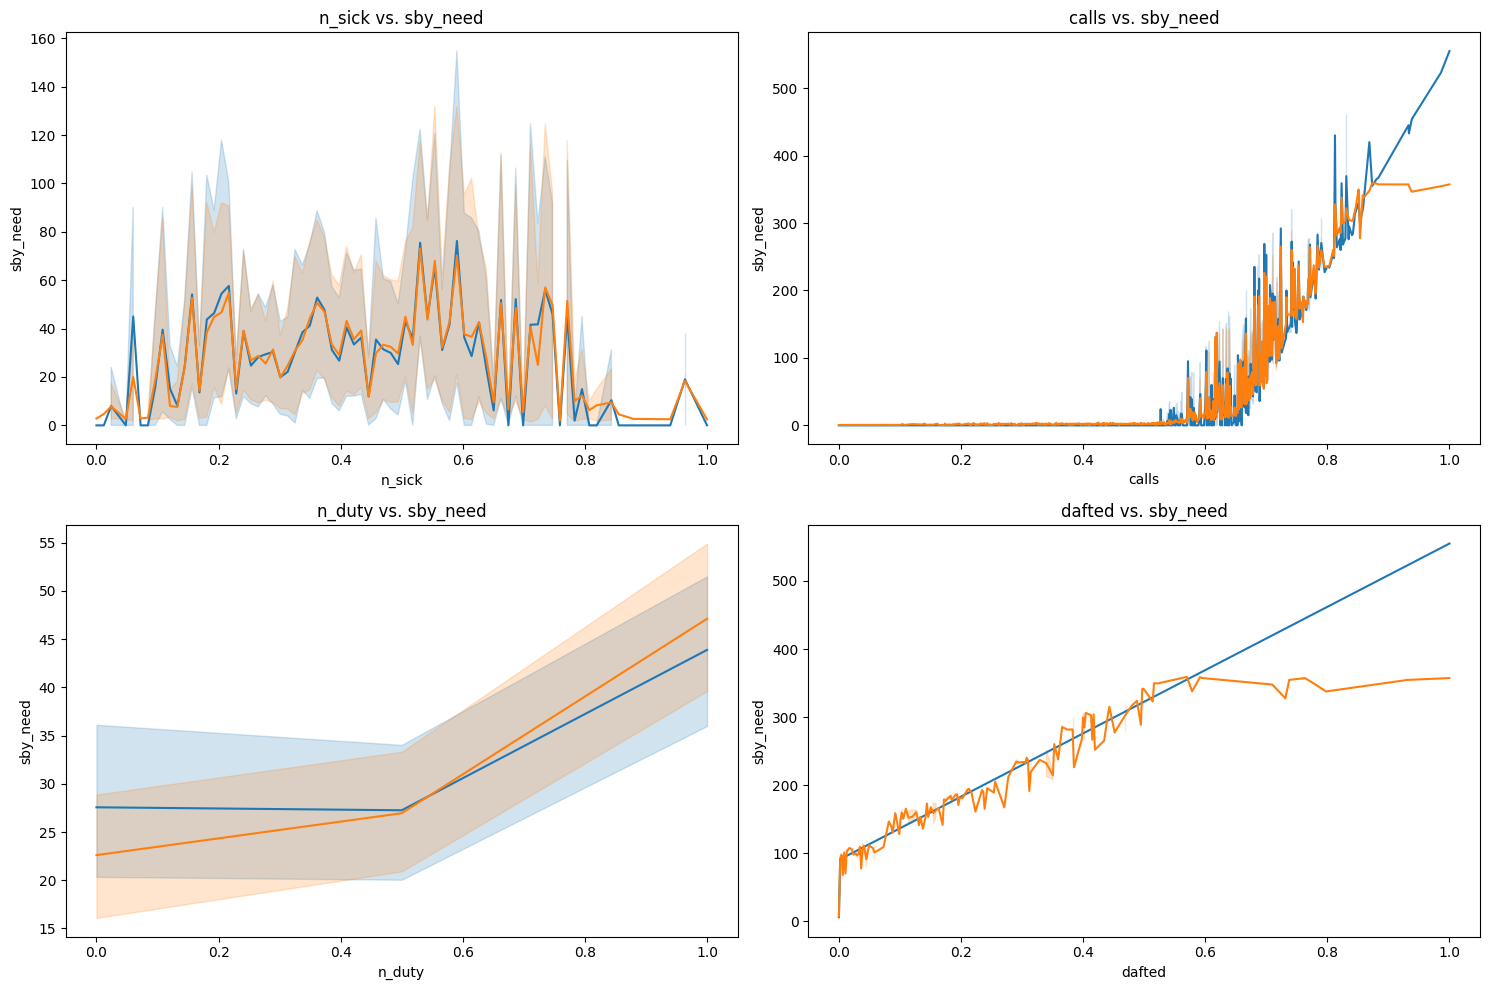

In [47]:
# Plotting Random Forest prediction plots
data_preds = plot_efficency(model)
data['Standby drivers need Predicted'] = data_preds
data.to_csv('Random_Forest_Regression_Output.csv', index=False)

**Legend:**

Blue Line - Actual

Orange Line - Predicted

Model: Random forest regressor
RMSE (Train): 15.99
RMSE (Test): 10.53
MAE (Train): 7.40
MAE (Test): 6.22
MAPE (Train): 1.12
MAPE (Test): 1.11
These metrics suggest that the random forest regressor model is a good choice for predicting the number of standby drivers needed. It is more accurate than the KNN regressor model and the SVR regressor model.

**2. Support Vector Regression (SVR)**

- Hyperparameters tuned via Randomized Search Cross-Validation with k = 7

In [48]:
from sklearn.svm import SVR

In [49]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}


# Instantiate RandomizedSearchCV model
svr_model = RandomizedSearchCV(SVR(),
                              param_distributions=param_grid,
                              n_iter=2,
                              cv=7,
                              verbose=True)

In [50]:
# Model fit for SVM with default parameters
svr_model.fit(x_train, y_train)

Fitting 7 folds for each of 2 candidates, totalling 14 fits


RandomizedSearchCV(cv=7, estimator=SVR(), n_iter=2,
                   param_distributions={'C': [0.1, 1, 10, 100, 1000],
                                        'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                                        'kernel': ['rbf']},
                   verbose=True)

In [51]:
# Best Model
model = svr_model.best_estimator_
print(model)

SVR(C=1000, gamma=0.01)


In [52]:
# Support Vectors
svr_model.best_estimator_.support_vectors_

array([[0.40963855, 0.42438272, 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.42168675, 0.48225309, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.63855422, 0.79012346, 1.        , ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.37349398, 0.82175926, 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.46987952, 0.49537037, 1.        , ..., 0.        , 1.        ,
        0.        ],
       [0.40963855, 0.71141975, 1.        , ..., 1.        , 0.        ,
        0.        ]])

In [53]:
# Evaluation on Train Data - Showing appropriate metrics for regression problems
evaluate_model(svr_model, x_train, y_train, 'Train')

Train Root Mean Squared Error:  26.33847662480524
Train Mean Absolute Error:  15.091617429989968
Train Mean Absolute Percentage Error:  1.3974852734076332e+16


In [54]:
# Evaluation on Unseen test Data - Showing appropriate metrics for regression problems
evaluate_model(svr_model, x_test, y_test, 'Test')

Test Root Mean Squared Error:  23.709511376400137
Test Mean Absolute Error:  13.425035796873471
Test Mean Absolute Percentage Error:  1.647393271053678e+16


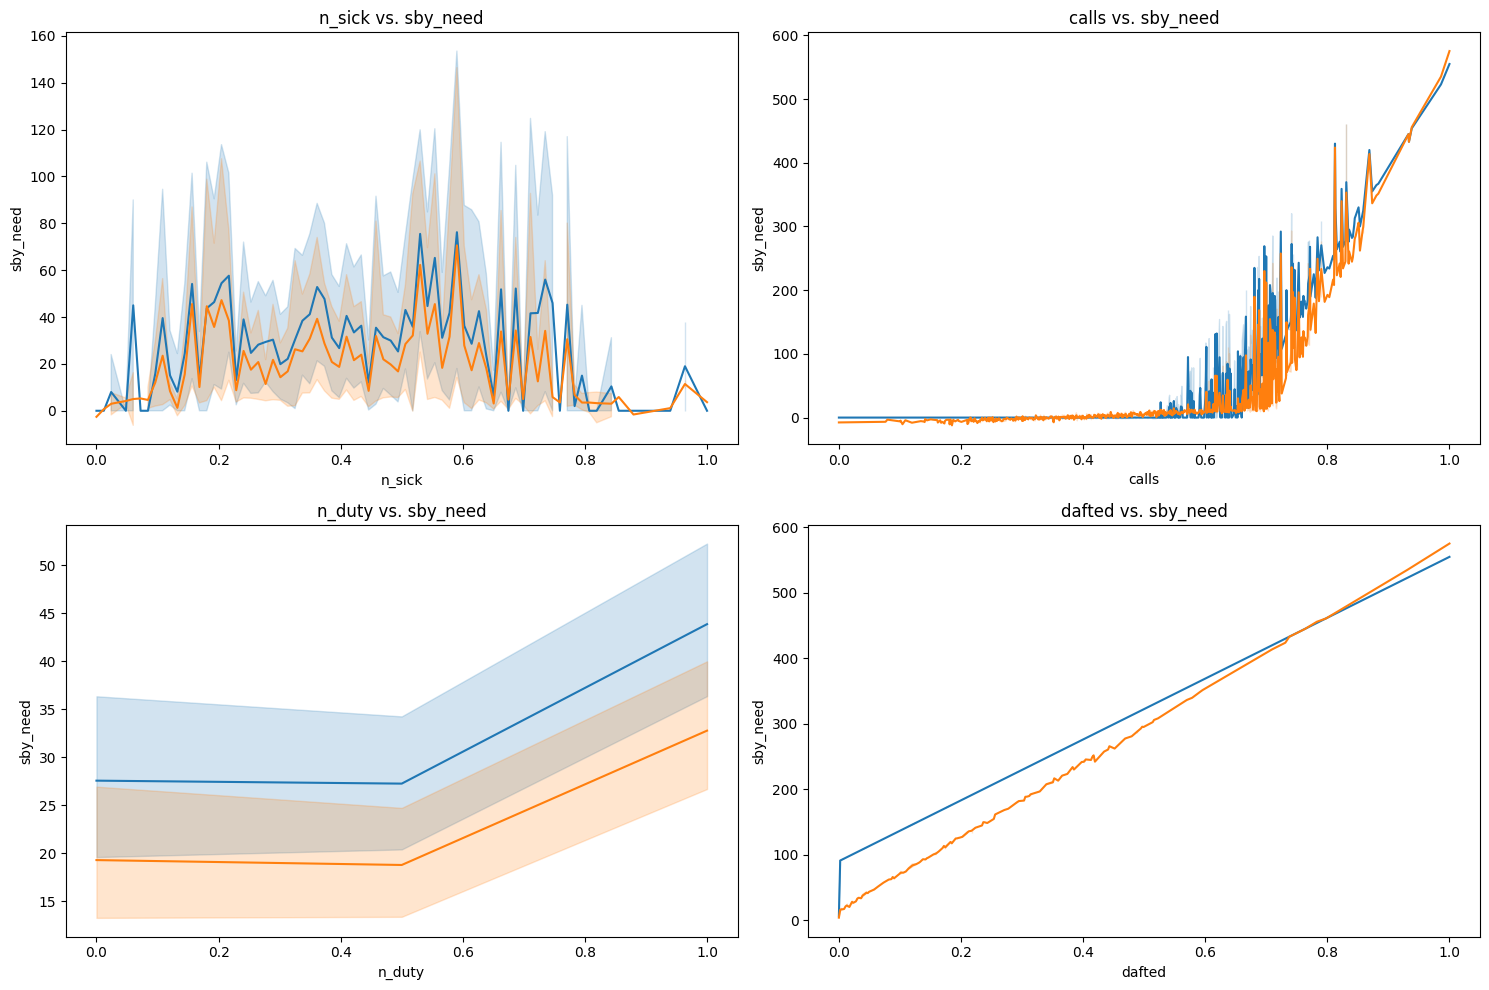

In [55]:
# Plotting SVR prediction plots
data_preds = plot_efficency(svr_model)
data['Standby drivers need Predicted'] = data_preds
data.to_csv('Support_Vector_Regression_Output.csv', index=False)

The RMSE, MAE, and MAPE for the SVR model are lower than the RMSE, MAE, and MAPE for the KNN regressor model. This suggests that the SVR model is more accurate than the KNN regressor model.

The RMSE of 26.34 on the training data and 23.71 on the test data for the SVR model is lower than the RMSE of 57.19 on the training data and 58.06 on the test data for the KNN regressor model. This means that the SVR model is on average closer to the actual values than the KNN regressor model.

The MAE of 15.09 on the training data and 13.43 on the test data for the SVR model is lower than the MAE of 30.47 on the training data and 33.16 on the test data for the KNN regressor model. This means that the SVR model has a smaller average error than the KNN regressor model.

The MAPE of 1.39 on the training data and 1.65 on the test data for the SVR model is lower than the MAPE of 4.74 on the training data and 7.01 on the test data for the KNN regressor model. This means that the SVR model has a smaller average percentage error than the KNN regressor model.

Overall, the results suggest that the SVR model is more accurate than the KNN regressor model for predicting the number of standby drivers needed.

Insights

Visualization shows the relationship between the number of emergency calls, the number of sick drivers, and the number of standby drivers needed. The visualization is a line chart, which is a good choice for showing trends over time.

The line chart shows that the number of standby drivers needed increases as the number of emergency calls increases. The number of standby drivers also increases as the number of sick drivers increases. This is to be expected, as more standby drivers are needed to meet the demand for emergency calls when there are more emergency calls or more sick drivers.

The visualization also shows that the number of standby drivers needed is not always constant. For example, the number of standby drivers needed is lower during the weekends than during the weekdays. This is likely due to the fact that there are fewer emergency calls during the weekends.

Overall, the visualization provides a good overview of the relationship between the number of emergency calls, the number of sick drivers, and the number of standby drivers needed. This information can be used to make decisions about standby duty planning.

Here are some specific insights that can be gained from the visualization:

The number of standby drivers needed is highest when there are a lot of emergency calls and a lot of sick drivers.
The number of standby drivers needed is lower during the weekends than during the weekdays.
The number of standby drivers needed can vary significantly from day to day.

**3. K-Nearest Neighbours (KNN) Regression**
- Hyperparameters tuned via Grid Search Cross-Validation with k = 7

In [56]:
from sklearn.neighbors import KNeighborsRegressor

In [57]:
# KNN Regressor Model
knr_clf = KNeighborsRegressor(n_jobs=-1)

knr_clf.get_params(deep=True)

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': -1,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [58]:
# Model Fitting
knr_clf.fit(x_train, y_train)

KNeighborsRegressor(n_jobs=-1)

In [59]:
# Evaluation on Train Data - Showing appropriate metrics for regression problems
evaluate_model(knr_clf, x_train, y_train, 'Train')

Train Root Mean Squared Error:  57.19346522735154
Train Mean Absolute Error:  30.46818675352877
Train Mean Absolute Percentage Error:  4.744085001609454e+16


In [60]:
# Evaluation on Unseen Test Data - Showing appropriate metrics for regression problems
evaluate_model(knr_clf, x_test, y_test, 'Test')

Test Root Mean Squared Error:  58.06328984569878
Test Mean Absolute Error:  33.15930735930736
Test Mean Absolute Percentage Error:  7.0100185368715816e+16


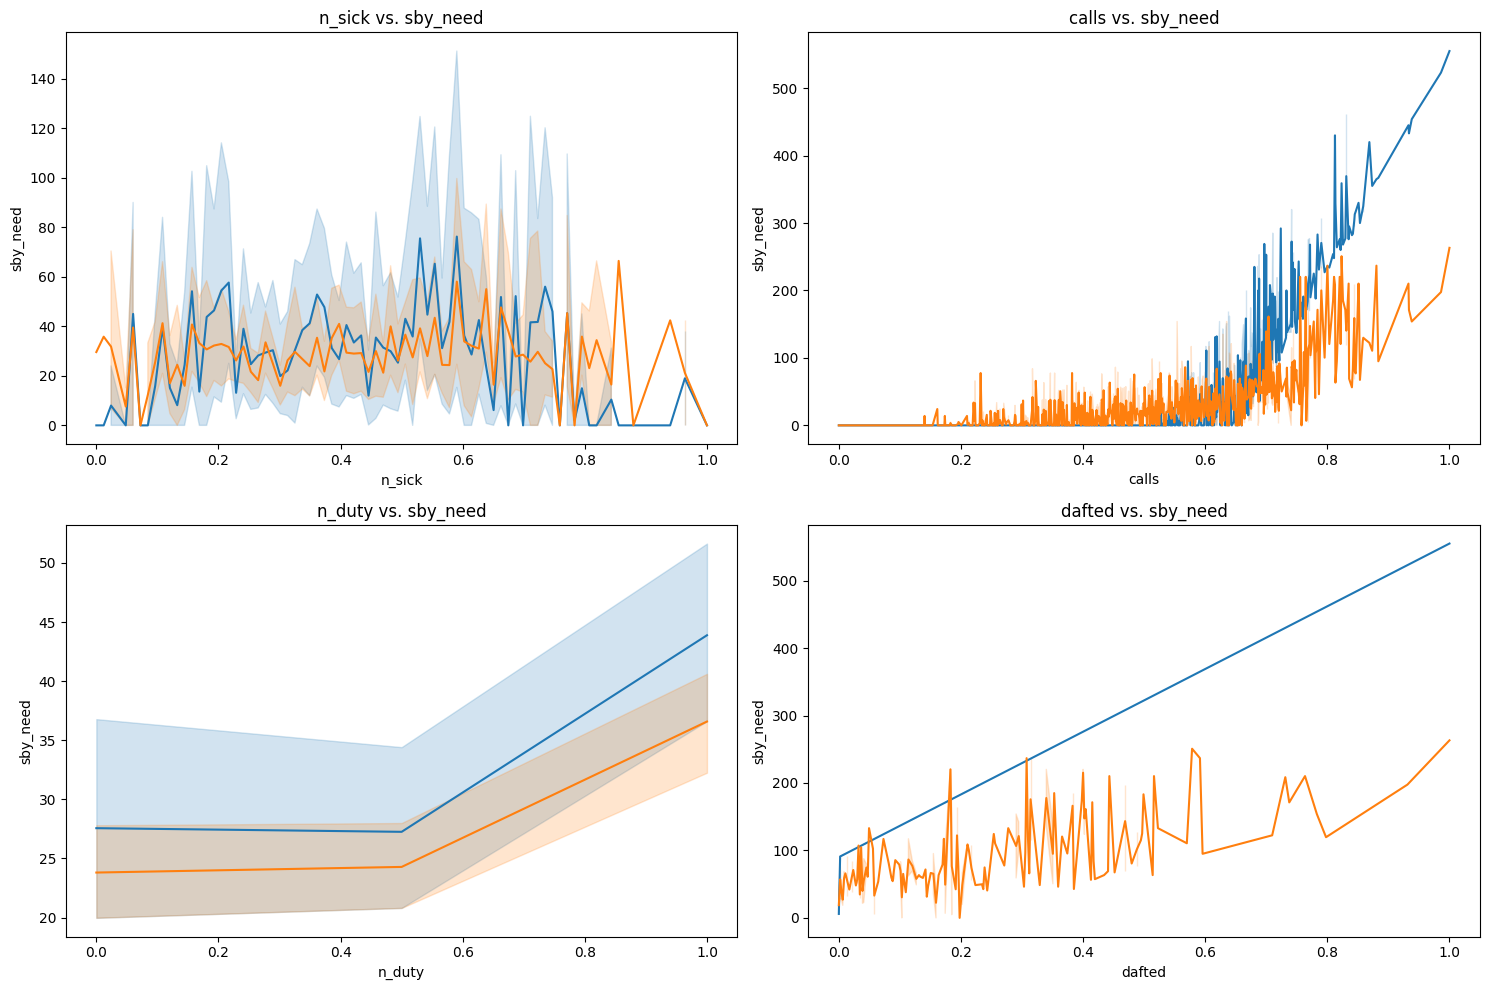

array([ 0.8, 14. ,  0. , ..., 84.6, 66.6, 22.8])

In [61]:
# Plotting KNN prediction plots (without Gridsearch)
plot_efficency(knr_clf)

**4. Polynomial Regression (Linear Regression with Polynomial Features) with L1 and L2 Regularization**
- Hyperparameters tuned via Grid Search Cross-Validation with k = 7

In [62]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [63]:
parameters = {
    'preprocessor__degree': (1, 2, 3),
    'preprocessor__include_bias': (True, False),
    'estimator__alpha': (0.5, 1, 5),
    'estimator__l1_ratio': (0.3, 0.5, 0.7)
}

# Pipeline of:
# polynomial feature engineering - to generate higher order polynomial terms from input features
# Elastic Net model - linear regression with both L1 and L2 regularization parameters
pipe = Pipeline(steps=[
    ('preprocessor', PolynomialFeatures()),
    ('estimator', ElasticNet(random_state=RANDOM_SEED))
])

# Hyperparameter tuning
clf = GridSearchCV(pipe,
                   parameters,
                   scoring='neg_mean_squared_error',
                   refit=True,
                   cv=7,  # k-folf cross-validation with k=7
                   verbose=False
                  )

In [64]:
# Performing GridSearch CV by fitting model on k - 1 folds of train data and
# validating on 1 fold of validation data and picking best model based on
# minimum validation MSE
clf.fit(x_train, y_train)

GridSearchCV(cv=7,
             estimator=Pipeline(steps=[('preprocessor', PolynomialFeatures()),
                                       ('estimator',
                                        ElasticNet(random_state=42))]),
             param_grid={'estimator__alpha': (0.5, 1, 5),
                         'estimator__l1_ratio': (0.3, 0.5, 0.7),
                         'preprocessor__degree': (1, 2, 3),
                         'preprocessor__include_bias': (True, False)},
             scoring='neg_mean_squared_error', verbose=False)

In [65]:
# Best Model
model = clf.best_estimator_
print(model)

Pipeline(steps=[('preprocessor', PolynomialFeatures(degree=3)),
                ('estimator',
                 ElasticNet(alpha=0.5, l1_ratio=0.7, random_state=42))])


In [66]:
# Evaluation on Train Data - Showing appropriate metrics for regression problems
evaluate_model(model, x_train, y_train, 'Train')

Train Root Mean Squared Error:  45.910219716890616
Train Mean Absolute Error:  31.19642924492523
Train Mean Absolute Percentage Error:  6.809569401954974e+16


In [67]:
# Evaluation on Unseen Test Data - Showing appropriate metrics for regression problems
evaluate_model(model, x_test, y_test, 'Test')

Test Root Mean Squared Error:  40.02657398722869
Test Mean Absolute Error:  27.662014674735786
Test Mean Absolute Percentage Error:  7.034096701328678e+16


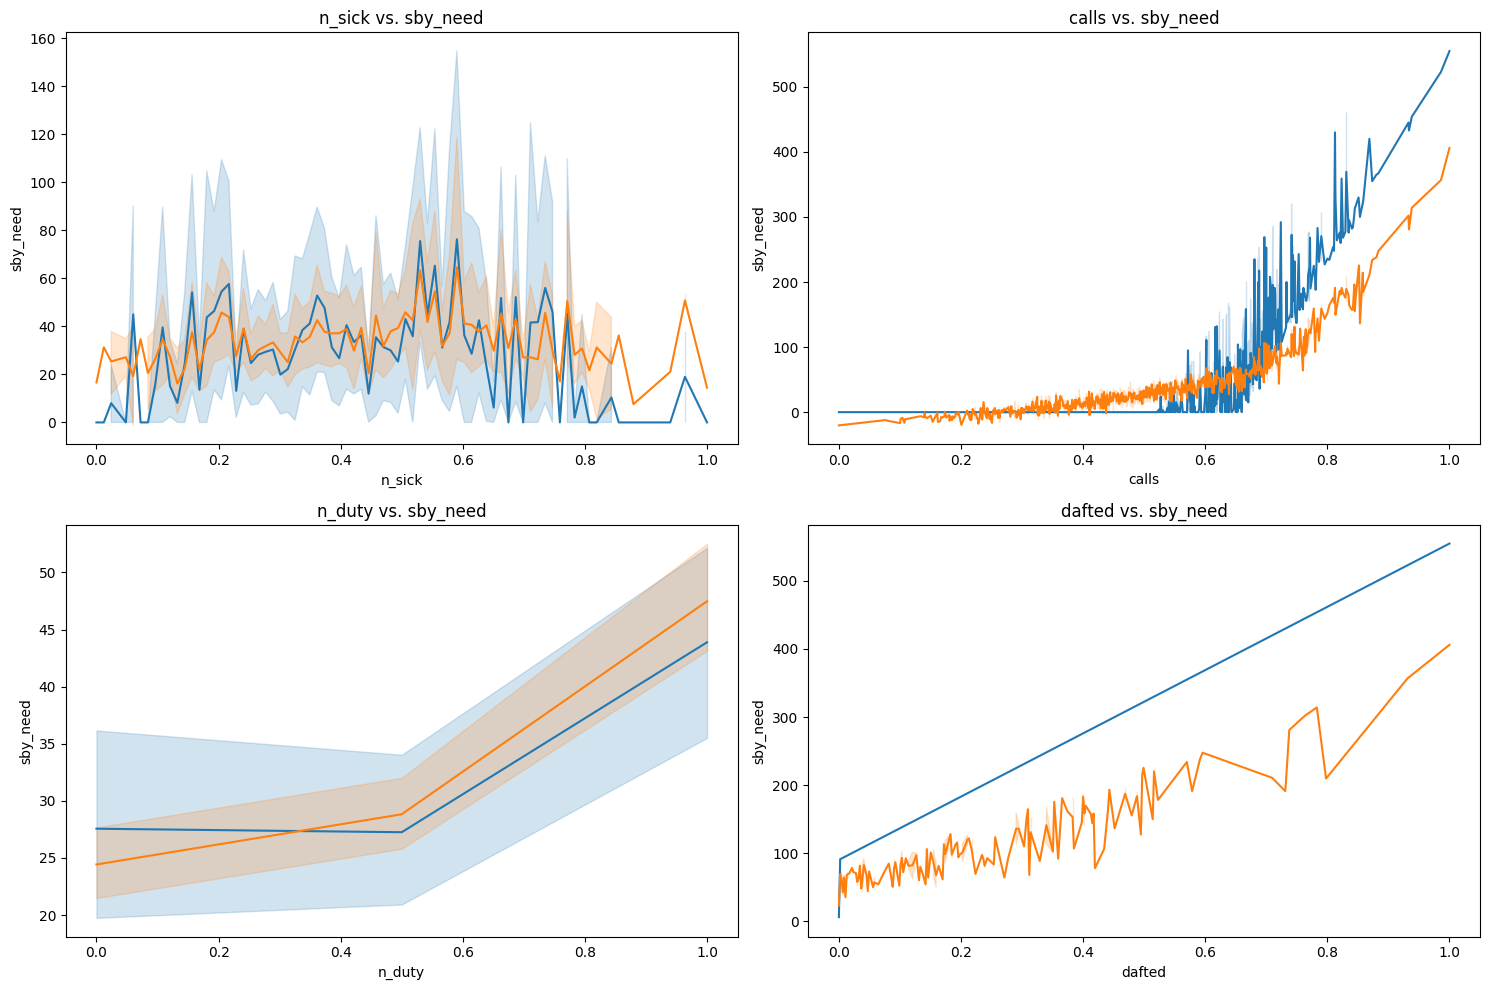

In [68]:
# Plotting Polynomial Regression prediction plots
data_preds = plot_efficency(model)
data['Standby drivers need Predicted'] = data_preds
data.to_csv('Polynomial_Regression_Output.csv', index=False)

In [70]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor  # Import XGBoost regressor